# Optimization Project

In this Jupyter notebook, we will be using the Frank-Wolfe optimization algorithm to minimize the variance function of a portfolio in Markowitz's portfolio theory. Markowitz's theory focuses on optimizing investment portfolios by considering the trade-off between expected returns and risk. The variance function represents the risk component of the portfolio, and by minimizing it, we aim to find the optimal allocation of assets that balances risk and return. The Frank-Wolfe algorithm is an iterative optimization method that iteratively finds the direction of steepest descent to minimize the objective function. By applying this algorithm to the portfolio variance function, we can determine an efficient portfolio allocation that maximizes returns while minimizing risk. Let's dive into the details and explore the power of the Frank-Wolfe algorithm for portfolio optimization.

In [1]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import hessian
import numdifftools as nd
import pandas as pd
import numpy as np
import scipy

In [2]:
PORTFOLIOS = ["EUROSTOXX_50", "FTSE_100", "MIBTEL_295", "SP_500", "NASDAQ"] 
PORTFOLIO = PORTFOLIOS[1] #CHANGE
RISK_AVERSION = 0.02

In [3]:
# Read the text file
name = pd.read_csv(PORTFOLIO+'/data/list.txt', delimiter='\t')
price_time = np.loadtxt(PORTFOLIO+'/data/price_time.txt', delimiter='\t')
ret_time = np.loadtxt(PORTFOLIO+'/data/Ret_time.txt', delimiter='\t')
ret_mean = np.loadtxt(PORTFOLIO+'/data/MRet.txt', delimiter='\t')
cov = np.loadtxt(PORTFOLIO+'/data/Cov.txt', delimiter='\t')
time = pd.read_csv(PORTFOLIO+'/data/time.txt', delimiter='\t')

# Solution
ret_risk = pd.read_csv(PORTFOLIO+'/solutions/RetRisk_SolVal.txt', delimiter='\t')

# Other variable
nStocks = len(name) + 1

## Portfolios Data

Portfolio: FTSE_100 
N. Stock: 79
From: 17-Mar-2003  To: 24-Mar-2008 


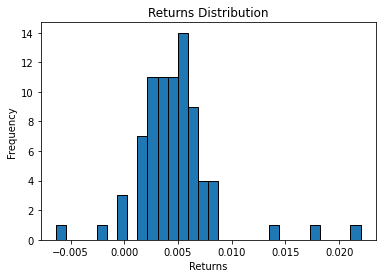

In [4]:
# Print Portfolio data
print(f"Portfolio: {PORTFOLIO} \nN. Stock: {nStocks}")
print(f"From: {time.iloc[0, 0]} To: {time.iloc[-1, 0]}")

plt.hist(ret_mean, bins=30, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Returns Distribution')
plt.show()

In [5]:
#Choose x1 in C
def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

e = np.ones((nStocks, 1))
weights = generate_random_array(nStocks)

print(f"B: {np.dot(e.T, weights)}")
print(sum(weights))
np.all(weights > 0)

B: [1.]
1.0000000000000002


True

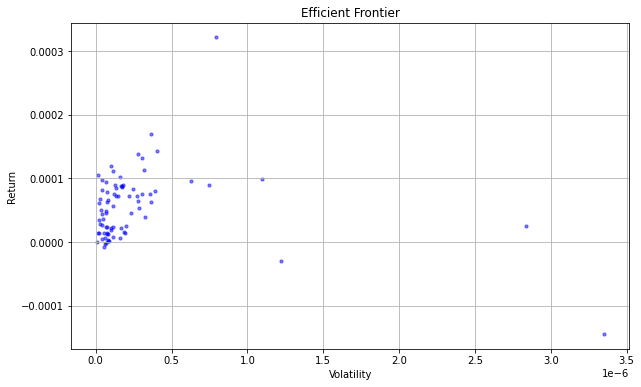

In [6]:
port_returns = []
port_volatility = []

for idx, w in enumerate(weights):
    port_returns.append(np.dot(w, ret_mean[idx]))

port_volatility = np.diag(np.dot(np.dot(cov, np.diag(weights)), cov.T))

plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, marker='o', color='b', s=10, alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

# Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$



the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [7]:
def checkMeanRet(weights):
    return np.dot(ret_mean.T, weights)

def checkSumOne(weights):
    return np.sum(weights) - 1

In [8]:
def riskFunction(weights):
    return np.dot(w.T, np.dot(cov, weights))

def loss(weights):
    return RISK_AVERSION * np.dot(weights.T, np.dot(cov, weights)) - np.dot(ret_mean.T, weights)

## Hessian and Lipschitz constant

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.

In [9]:
def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

In [10]:
%%time
#print("Hessian matrix")
#hessian = nd.Hessian(loss)(weights)

# Strong convexity is used for providing linear convergence
# rate of many gradient descent based algorithms
print("Calculating sigma (strongly convex)")
##sigma = is_strongly_convex(hessian)
#is_sc = sigma > 0

#if is_sc: print(f"Sigma: {sigma}, strongly convex")
#else: print(f"Sigma: {sigma}, not strongly convex")

#L = lipschitz_constant(hessian)
#print(f"Lipschitz constant: {L}")

#print("Lipschitz constant for single variable")
#Li = np.repeat(L, len(hessian))

Calculating sigma (strongly convex)
CPU times: user 78 µs, sys: 223 µs, total: 301 µs
Wall time: 57 µs


## Gradient

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [11]:
def gradient(w):
    return RISK_AVERSION * 2 * np.dot(cov, w) - ret_mean.T

# Projected Gradient, Frank-Wolfe and Pairwise Frank-Wolfe over the Markowitz portfolio problems

## Frank-Wolfe Method

In [26]:
def linear_solver(grad):
    c = grad # Use the positive gradient for minimization
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    return res.x

def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linear_solver(grad)
    return np.dot(grad, weights - s)

In [29]:
%%time

ITERATIONS = 500

weights = generate_random_array(nStocks)
loss_values_fw = []
grad_values_fw = []
returns_iteration_fw = []
optimal_indices_fw = []
optimal_values_fw = []

prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    grad = gradient(weights)
    s = linear_solver(grad)
    direction = s - weights

    # Store values for plotting
    loss_values_fw.append(loss(weights))
    grad_values_fw.append(np.linalg.norm(grad))
    returns_iteration_fw.append(checkMeanRet(weights))

    # Find the indices of the components with the maximum value in the direction
    max_value = np.max(direction) # or np.min(direction) depending on the context
    optimal_values_fw.append(max_value)
    optimal_indices = np.where(direction == max_value)[0]
    optimal_indices_fw.append(optimal_indices.tolist())

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break
    
    step_size = 2 / (itr + 2) #CONTROLLA 
    weights_new = weights + step_size * direction
    weights_new /= np.sum(weights_new)  # Normalizing the updated weights

    current_loss = loss(weights_new)
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if abs(prev_loss - current_loss) < 1e-6:
    #    print('Break itr: ', itr)
    #    break

    weights = weights_new
    prev_loss = current_loss

print("Final Weights: ", weights[:4])
print("Sum weights: ", np.sum(weights))

Duality Gap Convergence itr:  176
Final Weights:  [1.13601206e-06 1.86317006e-07 2.94301205e-07 4.72435858e-07]
Sum weights:  1.0
CPU times: user 138 ms, sys: 5.88 ms, total: 144 ms
Wall time: 143 ms


In [30]:
data = {
    'Returns': returns_iteration_fw,
    'Index i Optimal Sol': optimal_indices_fw,
    'Optimal Values FW': optimal_values_fw
}

df = pd.DataFrame(data)
df

,Returns,Index i Optimal Sol,Optimal Values FW
0,0.004605,[12],0.997856
1,0.016198,[12],0.332619
2,0.019096,[12],0.166309
3,0.020255,[12],0.099786
4,0.020835,[12],0.066524
...,...,...,...
171,0.021993,[12],0.000067
172,0.021993,[12],0.000066
173,0.021993,[12],0.000066
174,0.021993,[12],0.000065


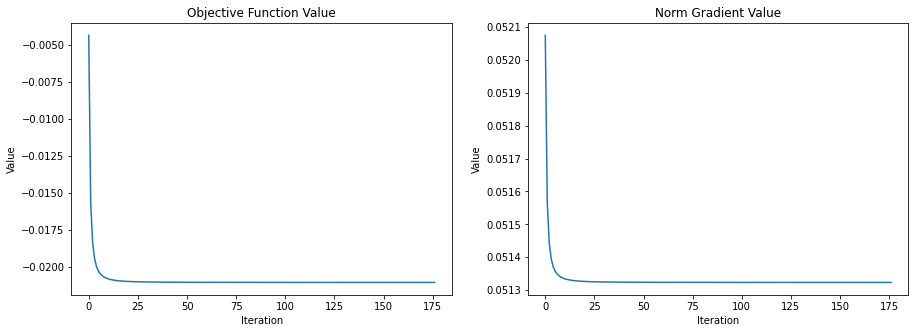

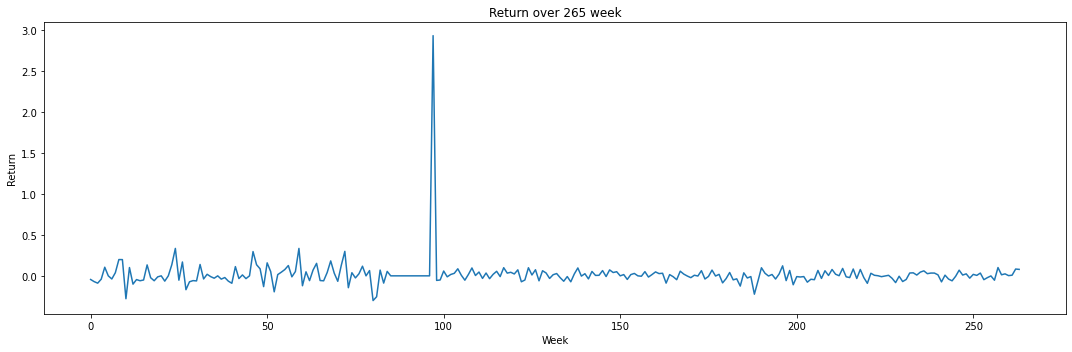

Final weights: [2.84991587e-07 2.16602800e-07 9.53977191e-07 7.82668380e-07]
Sum of weights: 1.0
Return Portfolio:  2.1992846927463243 %


In [15]:
# Plotting the metrics
plt.figure(figsize=(15, 5))

# Loss Function Values
plt.subplot(1, 2, 1)
plt.plot(loss_values_fw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 2, 2)
plt.plot(grad_values_fw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Return over 264 weeks
ret_mean_weeks_fw = np.dot(ret_time, weights)

plt.figure(figsize=(15, 5))
plt.plot(ret_mean_weeks_fw)
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

ret_mean_fw = checkMeanRet(weights) * 100
print("Final weights:", weights[:4])
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', ret_mean_fw, "%")

## Pairwise Frank-Wolfe

In [16]:
def pairwise_fw_update(grad, w):
    """
    Compute the Pairwise Frank-Wolfe direction.
    """
    # Identifying the two components of the gradient to modify
    i = np.argmax(grad)
    j = np.argmin(grad)
    
    # Constructing the direction vector
    d = np.zeros_like(grad)
    d[i] = -w[i]
    d[j] = 1-w[j]
    
    return d


In [32]:
%%time
ITERATIONS = 500

# Initialize weights and other parameters
weights = generate_random_array(nStocks)
loss_values_pairwise = []
grad_values_pairwise = []
returns_iteration_pairwise = []
optimal_indices_pairwise = []
optimal_values_pairwise = []
prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    grad = gradient(weights)
    direction = pairwise_fw_update(grad, weights)
    
    # Store values for plotting
    loss_values_pairwise.append(loss(weights))
    grad_values_pairwise.append(np.linalg.norm(grad))
    returns_iteration_pairwise.append(checkMeanRet(weights))

    # Find the indices of the components with the maximum value in the direction
    max_value = np.max(direction) # or np.min(direction) depending on the context
    optimal_values_pairwise.append(max_value)
    optimal_indices = np.where(direction == max_value)[0]
    optimal_indices_pairwise.append(optimal_indices.tolist())

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break

    step_size = 2 / (itr + 2) #CONTROLLA
    weights_new = weights + step_size * direction
    weights_new /= np.sum(weights_new) # Normalizing the updated weights
    
    current_loss = loss(weights_new)
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if norm_update < 1e-6 or abs(prev_loss - current_loss) < 1e-6:
    #    print('Break itr: ', itr)
    #    break
    
    weights = weights_new
    prev_loss = current_loss

print("Final Weights: ", weights[:4])
print("Sum weights: ", np.sum(weights))

Final Weights:  [0.00210777 0.00103298 0.0013105  0.00102977]
Sum weights:  0.9999999999999997
CPU times: user 196 ms, sys: 3.19 ms, total: 199 ms
Wall time: 197 ms


In [33]:
data = {
    'Returns': returns_iteration_pairwise,
    'Index i Optimal Sol': optimal_indices_pairwise,
    'Optimal Values PFW': optimal_values_pairwise
}

df_pairwise = pd.DataFrame(data)
df_pairwise

,Returns,Index i Optimal Sol,Optimal Values PFW
0,0.004702,[12],0.985591
1,0.011623,[12],0.593323
2,0.014010,[12],0.457200
3,0.015249,[12],0.386370
4,0.016021,[12],0.342219
...,...,...,...
494,0.020489,[12],0.086255
495,0.020490,[12],0.086225
496,0.020490,[12],0.086196
497,0.020491,[12],0.086166


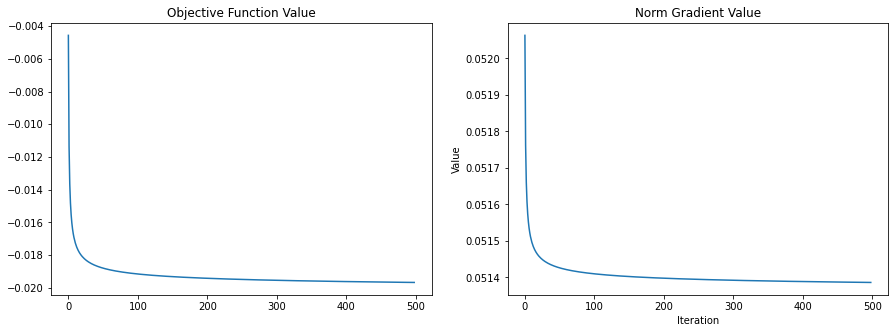

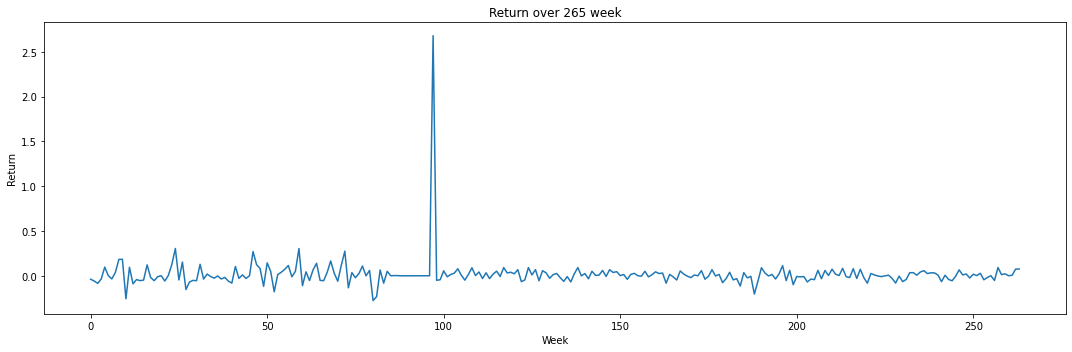

Final weights: (79,)
Sum of weights: 1.0
Return Portfolio:  2.0471760842092803 %


In [19]:
# Plotting the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values_pairwise)
plt.title('Objective Function Value')

plt.subplot(1, 2, 2)
plt.plot(grad_values_pairwise)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Return over 264 weeks
ret_mean_weeks_pairwise = np.dot(ret_time, weights)

plt.figure(figsize=(15, 5))
plt.plot(ret_mean_weeks_pairwise)
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')


plt.tight_layout()
plt.show()

ret_mean_pairwise = checkMeanRet(weights) * 100
print("Final weights:", weights.shape)
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', ret_mean_pairwise, "%")

## Comparison

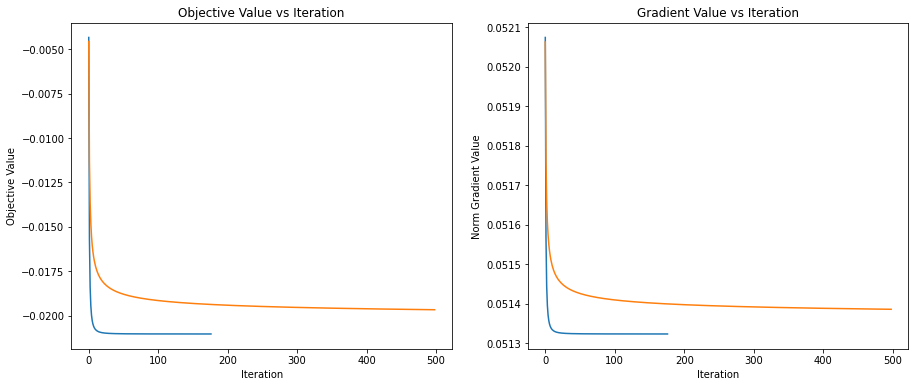

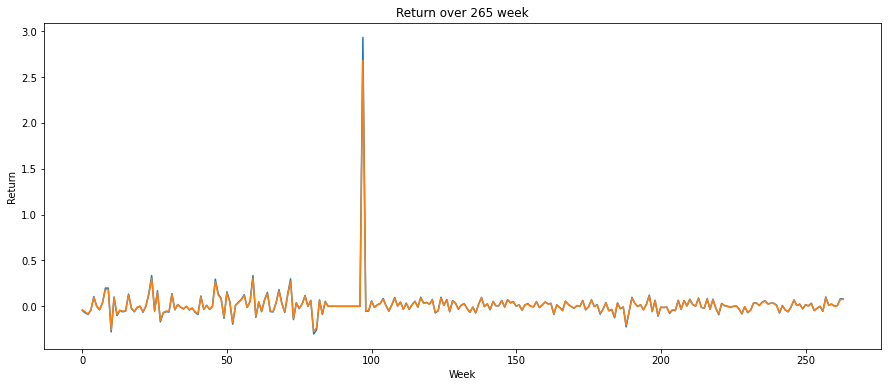

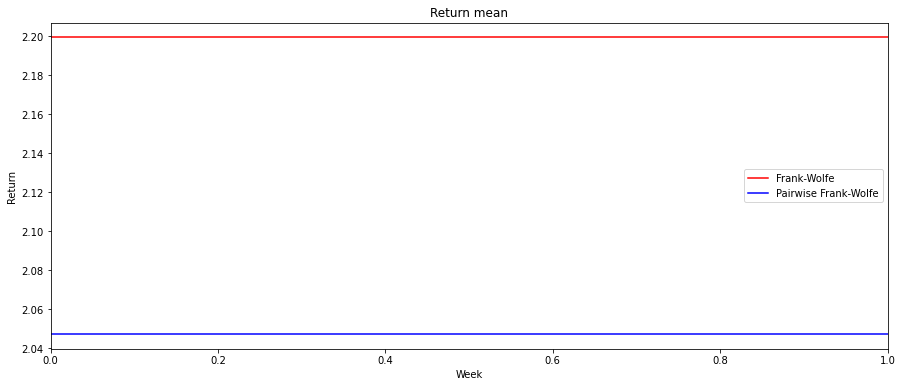

In [20]:
# Plotting Objective Values for both methods
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_values_fw, label='Frank-Wolfe')
plt.plot(loss_values_pairwise, label='Pairwise Frank-Wolfe')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Iteration')

plt.subplot(1, 2, 2)
plt.plot(grad_values_fw, label='Frank-Wolfe')
plt.plot(grad_values_pairwise, label='Pairwise Frank-Wolfe')
plt.xlabel('Iteration')
plt.ylabel('Norm Gradient Value')
plt.title('Gradient Value vs Iteration')

# Return over 264 weeks
ret_mean_weeks = np.dot(ret_time, weights)

plt.figure(figsize=(15, 6))
plt.plot(ret_mean_weeks_fw, label='Frank-Wolfe')
plt.plot(ret_mean_weeks_pairwise, label='Pairwise Frank-Wolfe')
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')

# Return mean
ret_mean_weeks = np.dot(ret_time, weights)

plt.figure(figsize=(15, 6))
plt.axhline(ret_mean_fw, label='Frank-Wolfe', color='r')
plt.axhline(ret_mean_pairwise, label='Pairwise Frank-Wolfe', color='b')
plt.title('Return mean')
plt.xlabel('Week')
plt.ylabel('Return')


plt.legend()
plt.show()